# Overview — Java (CSV-only)

Summarizes Java-centric findings **from pre-generated CSVs** under `../reports/java-csv/`.

Covers:
- **Annotations** usage (overall and per artifact),
- **Reflection** usage (summary and hotspots),
- **Deprecated** API usage,
- **Web endpoints** via Spring/Jakarta annotations.

This version includes stronger column detection, numeric coercion, NaN-safe plotting, and fallback aggregation when a numeric column is missing.

## Expected CSV location
Relative to this notebook (assumed in `<repo>/jupyter/`), data is read from `<repo>/reports/java-csv/`.

In [1]:
# --- Paths & CSV helpers ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent  # assuming <repo>/jupyter/
JAVA_DIR = ROOT / "reports" / "java-csv"

print("JAVA_DIR ->", JAVA_DIR.resolve())
print("CSV files in java-csv/:")
for p in sorted(JAVA_DIR.glob("*.csv")):
    print(" -", p.name)

def read_csv_or_empty(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"[warn] Missing CSV: {path.name}")
        return pd.DataFrame()
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception as e:
        print(f"[warn] Failed to read CSV: {path.name} -> {e}")
        return pd.DataFrame()

# Known files from your layout
df_annotations                 = read_csv_or_empty(JAVA_DIR / "AnnotatedCodeElements.csv")
df_annotations_per_artifact    = read_csv_or_empty(JAVA_DIR / "AnnotatedCodeElementsPerArtifact.csv")
df_reflection                  = read_csv_or_empty(JAVA_DIR / "ReflectionUsage.csv")
df_reflection_detailed         = read_csv_or_empty(JAVA_DIR / "ReflectionUsageDetailed.csv")
df_deprecated                  = read_csv_or_empty(JAVA_DIR / "DeprecatedElementUsage.csv")
df_deprecated_detailed         = read_csv_or_empty(JAVA_DIR / "DeprecatedElementUsageDetailed.csv")
df_spring_web                  = read_csv_or_empty(JAVA_DIR / "Spring_Web_Request_Annotations.csv")
df_jakarta_rest                = read_csv_or_empty(JAVA_DIR / "JakartaEE_REST_Annotations.csv")

print("Shapes:",
      "ann", df_annotations.shape,
      "ann/art", df_annotations_per_artifact.shape,
      "refl", df_reflection.shape,
      "refl_d", df_reflection_detailed.shape,
      "depr", df_deprecated.shape,
      "depr_d", df_deprecated_detailed.shape,
      "spring", df_spring_web.shape,
      "jakarta", df_jakarta_rest.shape)

JAVA_DIR -> /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/java-csv
CSV files in java-csv/:
 - AnnotatedCodeElements.csv
 - AnnotatedCodeElementsPerArtifact.csv
 - DeprecatedElementUsage.csv
 - DeprecatedElementUsageDetailed.csv
 - JakartaEE_REST_Annotations.csv
 - ReflectionUsage.csv
 - ReflectionUsageDetailed.csv
 - Spring_Web_Request_Annotations.csv
Shapes: ann (829, 5) ann/art (829, 6) refl (1, 5) refl_d (3418, 4) depr (8, 5) depr_d (7850, 5) spring (332, 8) jakarta (0, 7)


In [2]:
# --- Column/plot helpers ---
from typing import List, Optional

def to_numeric_safe(s):
    """Coerce to numeric; gracefully handle None/scalars."""
    if s is None:
        return pd.Series([], dtype="float64")
    if not hasattr(s, "__array__") and not hasattr(s, "dtype"):
        return pd.to_numeric(pd.Series([s]), errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def pick_first(df: pd.DataFrame, candidates: List[str], kind: Optional[str]=None) -> Optional[str]:
    if df.empty:
        return None
    if kind is None:
        for c in candidates:
            if c in df.columns:
                return c
        return None
    elif kind == "numeric":
        for c in df.columns:
            if pd.api.types.is_numeric_dtype(df[c]):
                return c
        return None
    elif kind == "text":
        for c in df.columns:
            if not pd.api.types.is_numeric_dtype(df[c]):
                return c
        return None
    return None

def find_artifact_col(df: pd.DataFrame) -> Optional[str]:
    prefs = ["artifact.fileName","artifact","fileName","filename","name","artifactName"]
    for c in prefs:
        if c in df.columns:
            return c
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]) and df[c].notna().sum() >= 2:
            return c
    return None

def find_numeric_col(df: pd.DataFrame, preferred=None, exclude=None):
    preferred = preferred or []
    exclude = set(exclude or [])
    for c in preferred:
        if c in df.columns and c not in exclude:
            return c
    for c in df.columns:
        if c in exclude:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    for c in df.columns:
        if c in exclude:
            continue
        if pd.to_numeric(df[c], errors="coerce").notna().any():
            return c
    return None

try:
    import plotly.express as px
    HAS_PLOTLY = True
except Exception:
    HAS_PLOTLY = False

def bar_smart(df: pd.DataFrame, name_col: str, value_col: str, title: str, ylabel: str, top_n: int = 20):
    if df.empty:
        print(f"[info] '{title}': empty dataframe.")
        return
    if not name_col:
        print(f"[info] '{title}': could not detect name column.")
        return
    if not value_col:
        print(f"[info] '{title}': could not detect numeric column.")
        return
    if name_col not in df.columns or value_col not in df.columns:
        print(f"[info] '{title}': columns not found ->", name_col, value_col)
        return

    sub = df[[name_col, value_col]].copy()
    sub[name_col] = sub[name_col].astype(str)
    sub[value_col] = to_numeric_safe(sub[value_col])
    sub = sub.dropna(subset=[name_col, value_col])
    sub = sub[sub[name_col].str.strip().ne("")]
    if sub.empty:
        print(f"[info] '{title}': no rows to plot after cleaning.")
        return
    sub = sub.sort_values(value_col, ascending=False).head(top_n)
    display(sub)
    if HAS_PLOTLY:
        fig = px.bar(sub, x=name_col, y=value_col, title=title, labels={name_col: "", value_col: ylabel})
        fig.update_layout(xaxis_tickangle=-60, height=450, margin=dict(l=20, r=20, t=60, b=40))
        fig.show()
    else:
        plt.figure(figsize=(10, 5))
        plt.bar(sub[name_col], sub[value_col])
        plt.xticks(rotation=60, ha="right")
        plt.ylabel(ylabel); plt.title(title); plt.tight_layout(); plt.show()

def pie_top_donut(df: pd.DataFrame, name_col: str, value_col: str, title: str, top_n: int = 10, others_label: str = "others"):
    if df.empty or name_col not in df.columns or value_col not in df.columns:
        print(f"[info] Missing columns for pie '{title}'")
        return
    work = df[[name_col, value_col]].copy()
    work[name_col] = work[name_col].astype(str)
    work[value_col] = to_numeric_safe(work[value_col]).fillna(0)
    work = work.sort_values(value_col, ascending=False)
    top = work.head(top_n)
    if len(work) > top_n:
        rest = work.iloc[top_n:][value_col].sum()
        top = pd.concat([top, pd.DataFrame({name_col:[others_label], value_col:[rest]})], ignore_index=True)
    tot = int(top[value_col].sum())
    fig, ax = plt.subplots(figsize=(8,8))
    wedges, texts, autotexts = ax.pie(
        top[value_col], labels=top[name_col],
        autopct=lambda pct: f"{pct:.1f}% ({int(tot*pct/100)})" if pct>=3 else "",
        pctdistance=0.8, labeldistance=1.05, wedgeprops=dict(width=0.4), startangle=90)
    ax.text(0,0,f"Total\n{tot:,}",ha="center",va="center",fontsize=11)
    ax.set_title(title, pad=12)
    plt.legend(wedges, top[name_col], bbox_to_anchor=(1.04,1), loc="upper left", fontsize=8)
    plt.tight_layout(); plt.show()


## 1) Annotations

,annotationName,languageElement,numberOfAnnotatedElements,examples,Source Cypher File: Java/Annotated_code_elements.cypher
0,com.google.gson.annotations.SerializedName,Field,10699,"com.stripe.model.Account$BusinessProfile.mcc,c...",NaN
1,lombok.Generated,Method,8214,com.stripe.exception.CardException.getDeclineC...,NaN
2,org.springframework.lang.Nullable,Parameter,5097,org.springframework.jdbc.core.JdbcTemplate$1Ba...,NaN
3,java.lang.Deprecated,Method,3903,org.springframework.boot.loader.Launcher.creat...,NaN
4,org.springframework.lang.Nullable,Method,3772,com.salesmanager.shop.store.controller.shoppin...,NaN
5,org.springframework.lang.Nullable,Field,2313,org.springframework.jdbc.core.JdbcTemplate$1Ba...,NaN
6,com.fasterxml.jackson.annotation.JsonProperty,Field,1750,"org.dmg.pmml.baseline.FieldValue.field,org.dmg...",NaN
7,org.jpmml.model.annotations.Property,Parameter,1689,"org.dmg.pmml.baseline.FieldValue.setField(0),o...",NaN
8,io.reactivex.annotations.CheckReturnValue,Method,1429,io.reactivex.flowables.ConnectableFlowable.ref...,NaN
9,javax.xml.bind.annotation.XmlAttribute,Field,1428,org.hibernate.boot.jaxb.cfg.spi.JaxbCfgCollect...,NaN


,annotationName,numberOfAnnotatedElements
0,com.google.gson.annotations.SerializedName,10699
1,lombok.Generated,8214
2,org.springframework.lang.Nullable,5097
3,java.lang.Deprecated,3903
4,org.springframework.lang.Nullable,3772
5,org.springframework.lang.Nullable,2313
6,com.fasterxml.jackson.annotation.JsonProperty,1750
7,org.jpmml.model.annotations.Property,1689
8,io.reactivex.annotations.CheckReturnValue,1429
9,javax.xml.bind.annotation.XmlAttribute,1428


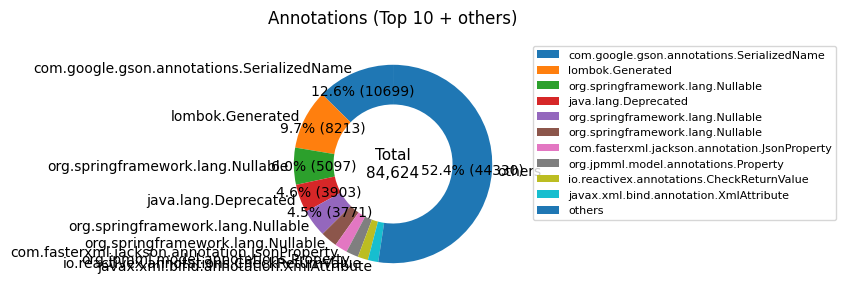

In [3]:
# Overall top annotations (from AnnotatedCodeElements.csv)
if not df_annotations.empty:
    ann_col = pick_first(df_annotations, ["annotation","Annotation","AnnotationName"], None) or pick_first(df_annotations, [], "text")
    cnt_col = pick_first(df_annotations, ["count","occurrences","uses"], None) or pick_first(df_annotations, [], "numeric")
    top = df_annotations.sort_values(cnt_col, ascending=False).head(20)
    display(top)
    bar_smart(top, ann_col, cnt_col, "Top 20 annotations", "uses")
    pie_top_donut(df_annotations, ann_col, cnt_col, "Annotations (Top 10 + others)")
else:
    print("[info] AnnotatedCodeElements.csv not found or empty.")


In [4]:
# Annotations per artifact (from AnnotatedCodeElementsPerArtifact.csv)
if not df_annotations_per_artifact.empty:
    art_col = find_artifact_col(df_annotations_per_artifact)
    cnt_col = pick_first(df_annotations_per_artifact, ["count","uses","occurrences"], None)
    if not cnt_col:
        cnt_col = find_numeric_col(df_annotations_per_artifact, preferred=["count","uses","occurrences"], exclude=[art_col])

    # If still missing, aggregate as a fallback: count rows per artifact
    if not cnt_col and art_col:
        tmp = df_annotations_per_artifact.copy()
        tmp[art_col] = tmp[art_col].astype(str)
        tmp = tmp[tmp[art_col].str.strip().ne("")]
        agg = tmp.groupby(art_col).size().reset_index(name="annotationUses")
        art_col, cnt_col = agg.columns[0], "annotationUses"
        bar_smart(agg, art_col, cnt_col, "Annotations per artifact (Top 20)", "uses")
    else:
        bar_smart(df_annotations_per_artifact, art_col, cnt_col, "Annotations per artifact (Top 20)", "uses")
else:
    print("[info] AnnotatedCodeElementsPerArtifact.csv not found or empty.")


,artifactName,numberOfAnnotatedElements
0,nan,10699
1,nan,8214
2,nan,5097
3,nan,3903
4,nan,3772
5,nan,2313
6,nan,1750
7,nan,1689
8,nan,1429
9,nan,1428


## 2) Reflection

In [5]:
# Reflection summary
if not df_reflection.empty:
    cnt_col = pick_first(df_reflection, ["count","uses","occurrences","members","calls"], None) or pick_first(df_reflection, [], "numeric")
    name_col = pick_first(df_reflection, ["package","Package","artifact","Artifact","type","Type"], None) or pick_first(df_reflection, [], "text")
    bar_smart(df_reflection, name_col, cnt_col, "Reflection usage (Top 20)", "uses")
else:
    print("[info] ReflectionUsage.csv not found or empty.")


[info] 'Reflection usage (Top 20)': no rows to plot after cleaning.


In [6]:
# Reflection hotspots (detailed)
if not df_reflection_detailed.empty:
    name_col = pick_first(df_reflection_detailed, ["Member","member","Method","method","Type","type","Class","class"], None) or pick_first(df_reflection_detailed, [], "text")
    cnt_col  = pick_first(df_reflection_detailed, ["count","uses","occurrences"], None) or pick_first(df_reflection_detailed, [], "numeric")
    bar_smart(df_reflection_detailed, name_col, cnt_col, "Reflection hotspots (Top 20)", "uses")
else:
    print("[info] ReflectionUsageDetailed.csv not found or empty.")


[info] 'Reflection hotspots (Top 20)': no rows to plot after cleaning.


## 3) Deprecated API usage

In [7]:
# Deprecated summary
if not df_deprecated.empty:
    name_col = pick_first(df_deprecated, ["symbol","Symbol","Target","target","API"], None) or pick_first(df_deprecated, [], "text")
    cnt_col  = pick_first(df_deprecated, ["count","references","uses","occurrences"], None) or pick_first(df_deprecated, [], "numeric")
    bar_smart(df_deprecated, name_col, cnt_col, "Deprecated API (Top 20)", "references")
else:
    print("[info] DeprecatedElementUsage.csv not found or empty.")


[info] 'Deprecated API (Top 20)': no rows to plot after cleaning.


In [8]:
# Deprecated hotspots (detailed)
if not df_deprecated_detailed.empty:
    name_col = pick_first(df_deprecated_detailed, ["symbol","member","method","type","class","Target"], None) or pick_first(df_deprecated_detailed, [], "text")
    cnt_col  = pick_first(df_deprecated_detailed, ["count","references","uses","occurrences"], None) or pick_first(df_deprecated_detailed, [], "numeric")
    bar_smart(df_deprecated_detailed, name_col, cnt_col, "Deprecated hotspots (Top 20)", "references")
else:
    print("[info] DeprecatedElementUsageDetailed.csv not found or empty.")


[info] 'Deprecated hotspots (Top 20)': no rows to plot after cleaning.


## 4) Web endpoints (Spring/Jakarta)

In [9]:
# Spring web request annotations
if not df_spring_web.empty:
    ann_col = pick_first(df_spring_web, ["annotation","Annotation","AnnotationName"], None) or pick_first(df_spring_web, [], "text")
    cnt_col = pick_first(df_spring_web, ["count","occurrences","uses"], None) or pick_first(df_spring_web, [], "numeric")
    bar_smart(df_spring_web, ann_col, cnt_col, "Spring Web request annotations (Top 20)", "uses")
else:
    print("[info] Spring_Web_Request_Annotations.csv not found or empty.")


[info] 'Spring Web request annotations (Top 20)': no rows to plot after cleaning.


In [10]:
# Jakarta REST annotations
if not df_jakarta_rest.empty:
    ann_col = pick_first(df_jakarta_rest, ["annotation","Annotation","AnnotationName"], None) or pick_first(df_jakarta_rest, [], "text")
    cnt_col = pick_first(df_jakarta_rest, ["count","occurrences","uses"], None) or pick_first(df_jakarta_rest, [], "numeric")
    bar_smart(df_jakarta_rest, ann_col, cnt_col, "Jakarta REST annotations (Top 20)", "uses")
else:
    print("[info] JakartaEE_REST_Annotations.csv not found or empty.")


[info] JakartaEE_REST_Annotations.csv not found or empty.


## Appendix — Quick schema inspection
If any chart looks odd, inspect the actual columns to adjust detection rules.

In [11]:
def inspect(df: pd.DataFrame, name: str):
    print("\n---", name, "---")
    if df.empty:
        print("(empty)")
        return
    print("columns:", list(df.columns))
    display(df.head(5))
    print(df.info())

inspect(df_annotations, "AnnotatedCodeElements")
inspect(df_annotations_per_artifact, "AnnotatedCodeElementsPerArtifact")
inspect(df_reflection, "ReflectionUsage")
inspect(df_reflection_detailed, "ReflectionUsageDetailed")
inspect(df_deprecated, "DeprecatedElementUsage")
inspect(df_deprecated_detailed, "DeprecatedElementUsageDetailed")
inspect(df_spring_web, "Spring_Web_Request_Annotations")
inspect(df_jakarta_rest, "JakartaEE_REST_Annotations")



--- AnnotatedCodeElements ---
columns: ['annotationName', 'languageElement', 'numberOfAnnotatedElements', 'examples', 'Source Cypher File: Java/Annotated_code_elements.cypher']


,annotationName,languageElement,numberOfAnnotatedElements,examples,Source Cypher File: Java/Annotated_code_elements.cypher
0,com.google.gson.annotations.SerializedName,Field,10699,"com.stripe.model.Account$BusinessProfile.mcc,c...",NaN
1,lombok.Generated,Method,8214,com.stripe.exception.CardException.getDeclineC...,NaN
2,org.springframework.lang.Nullable,Parameter,5097,org.springframework.jdbc.core.JdbcTemplate$1Ba...,NaN
3,java.lang.Deprecated,Method,3903,org.springframework.boot.loader.Launcher.creat...,NaN
4,org.springframework.lang.Nullable,Method,3772,com.salesmanager.shop.store.controller.shoppin...,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   annotationName                                           829 non-null    object 
 1   languageElement                                          829 non-null    object 
 2   numberOfAnnotatedElements                                829 non-null    int64  
 3   examples                                                 829 non-null    object 
 4   Source Cypher File: Java/Annotated_code_elements.cypher  0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 32.5+ KB
None

--- AnnotatedCodeElementsPerArtifact ---
columns: ['artifactName', 'annotationName', 'languageElement', 'numberOfAnnotatedElements', 'examples', 'Source Cypher File: Java/Annotated_code_elements_per_artifact.cypher']


,artifactName,annotationName,languageElement,numberOfAnnotatedElements,examples,Source Cypher File: Java/Annotated_code_elements_per_artifact.cypher
0,NaN,com.google.gson.annotations.SerializedName,Field,10699,"com.stripe.model.Account$BusinessProfile.mcc,c...",NaN
1,NaN,lombok.Generated,Method,8214,com.stripe.exception.CardException.getDeclineC...,NaN
2,NaN,org.springframework.lang.Nullable,Parameter,5097,org.springframework.jdbc.core.JdbcTemplate$1Ba...,NaN
3,NaN,java.lang.Deprecated,Method,3903,org.springframework.boot.loader.Launcher.creat...,NaN
4,NaN,org.springframework.lang.Nullable,Method,3772,com.salesmanager.shop.store.controller.shoppin...,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 6 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   artifactName                                                          0 non-null      float64
 1   annotationName                                                        829 non-null    object 
 2   languageElement                                                       829 non-null    object 
 3   numberOfAnnotatedElements                                             829 non-null    int64  
 4   examples                                                              829 non-null    object 
 5   Source Cypher File: Java/Annotated_code_elements_per_artifact.cypher  0 non-null      float64
dtypes: float64(2), int64(1), object(3)
memory usage: 39.0+ KB
None

--- ReflectionUsage ---
columns: ['

,dependentArtifactName,numberOfReflectionCaller,someReflectionCaller,someReflectionTypes,Source Cypher File: Java/Java_Reflection_usage.cypher
0,NaN,91774,com.salesmanager.core.business.configuration.P...,"java.lang.reflect.ParameterizedType,java.lang....",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   dependentArtifactName                                  0 non-null      float64
 1   numberOfReflectionCaller                               1 non-null      int64  
 2   someReflectionCaller                                   1 non-null      object 
 3   someReflectionTypes                                    1 non-null      object 
 4   Source Cypher File: Java/Java_Reflection_usage.cypher  0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 172.0+ bytes
None

--- ReflectionUsageDetailed ---
columns: ['dependentArtifactName', 'reflectionCallerTypeName', 'reflectionTypes', 'Source Cypher File: Java/Java_Reflection_usage_detailed.cypher']


,dependentArtifactName,reflectionCallerTypeName,reflectionTypes,Source Cypher File: Java/Java_Reflection_usage_detailed.cypher
0,NaN,com.salesmanager.core.business.services.common...,java.lang.reflect.ParameterizedType,NaN
1,NaN,com.zaxxer.hikari.util.PropertyElf,"java.lang.reflect.Constructor,java.lang.reflec...",NaN
2,NaN,com.zaxxer.hikari.util.DriverDataSource,java.lang.reflect.Constructor,NaN
3,NaN,com.zaxxer.hikari.pool.ProxyConnection$ClosedC...,"java.lang.reflect.Proxy,java.lang.reflect.Method",NaN
4,NaN,com.zaxxer.hikari.util.JavassistProxyFactory,"java.lang.reflect.Method,java.lang.reflect.Array",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3418 entries, 0 to 3417
Data columns (total 4 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   dependentArtifactName                                           0 non-null      float64
 1   reflectionCallerTypeName                                        3418 non-null   object 
 2   reflectionTypes                                                 3418 non-null   object 
 3   Source Cypher File: Java/Java_Reflection_usage_detailed.cypher  0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 106.9+ KB
None

--- DeprecatedElementUsage ---
columns: ['artifactName', 'deprecatedElement', 'numberOfElementsUsingDeprecatedElements', 'someElementsUsingDeprecatedElements', 'Source Cypher File: Java/Java_deprecated_element_usage.cypher']


,artifactName,deprecatedElement,numberOfElementsUsingDeprecatedElements,someElementsUsingDeprecatedElements,Source Cypher File: Java/Java_deprecated_element_usage.cypher
0,NaN,Method,1587,com.salesmanager.shop.store.facade.content.Con...,NaN
1,NaN,Class,963,com.salesmanager.shop.store.controller.shoppin...,NaN
2,NaN,Field,1195,org.hibernate.type.descriptor.sql.spi.SqlTypeD...,NaN
3,NaN,Interface,564,"org.hibernate.type.SetType,org.hibernate.type....",NaN
4,NaN,Constructor,98,"org.hibernate.type.ManyToOneType.<init>,org.hi...",NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   artifactName                                                   0 non-null      float64
 1   deprecatedElement                                              8 non-null      object 
 2   numberOfElementsUsingDeprecatedElements                        8 non-null      int64  
 3   someElementsUsingDeprecatedElements                            8 non-null      object 
 4   Source Cypher File: Java/Java_deprecated_element_usage.cypher  0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 452.0+ bytes
None

--- DeprecatedElementUsageDetailed ---
columns: ['artifactName', 'deprecatedElementType', 'elementUsingDeprecatedElement', 'deprecatedElement', 'Source Cypher File: Java/Java_deprecat

,artifactName,deprecatedElementType,elementUsingDeprecatedElement,deprecatedElement,Source Cypher File: Java/Java_deprecated_element_usage_detailed.cypher
0,NaN,Method,aj.org.objectweb.asm.MethodVisitor.visitMethod...,"void visitMethodInsn(int,java.lang.String,java...",NaN
1,NaN,Interface,com.amazonaws.AmazonWebServiceClient,com.amazonaws.handlers.RequestHandler,NaN
2,NaN,Parameter,com.amazonaws.AmazonWebServiceClient.endClient...,NaN,NaN
3,NaN,Class,com.amazonaws.AmazonWebServiceRequest,com.amazonaws.internal.StaticCredentialsProvider,NaN
4,NaN,Constructor,com.amazonaws.auth.InstanceProfileCredentialsP...,void <init>(),NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7850 entries, 0 to 7849
Data columns (total 5 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   artifactName                                                            0 non-null      float64
 1   deprecatedElementType                                                   7850 non-null   object 
 2   elementUsingDeprecatedElement                                           7850 non-null   object 
 3   deprecatedElement                                                       7849 non-null   object 
 4   Source Cypher File: Java/Java_deprecated_element_usage_detailed.cypher  0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 306.8+ KB
None

--- Spring_Web_Request_Annotations ---
columns: ['path', 'httpMethod', 'resourceArtifact', 'resourceType', 'resourceMethod', 'a

,path,httpMethod,resourceArtifact,resourceType,resourceMethod,additionalHttpProperties,methodParameters,Source Cypher File: Java/Spring_Web_Request_Annotations.cypher
0,${server.error.path:${error.path:/error}}/,ALL,NaN,org.springframework.boot.autoconfigure.web.ser...,error,NaN,NaN,NaN
1,${server.error.path:${error.path:/error}}/,ALL,NaN,org.springframework.boot.autoconfigure.web.ser...,errorHtml,"produces: text/html,produces: text/html,produc...",NaN,NaN
2,/,ALL,NaN,com.salesmanager.shop.store.api.exception.Rest...,handleServiceException,"produces: application/json,produces: applicati...",NaN,NaN
3,/,ALL,NaN,com.salesmanager.shop.store.api.exception.Rest...,handleRestApiException,"produces: application/json,produces: applicati...",NaN,NaN
4,/,GET,NaN,com.salesmanager.shop.store.api.DefaultController,version,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 8 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   path                                                            332 non-null    object 
 1   httpMethod                                                      332 non-null    object 
 2   resourceArtifact                                                0 non-null      float64
 3   resourceType                                                    332 non-null    object 
 4   resourceMethod                                                  332 non-null    object 
 5   additionalHttpProperties                                        95 non-null     object 
 6   methodParameters                                                81 non-null     object 
 7   Source Cypher File: Java/Spring_Web_Request_Annotation